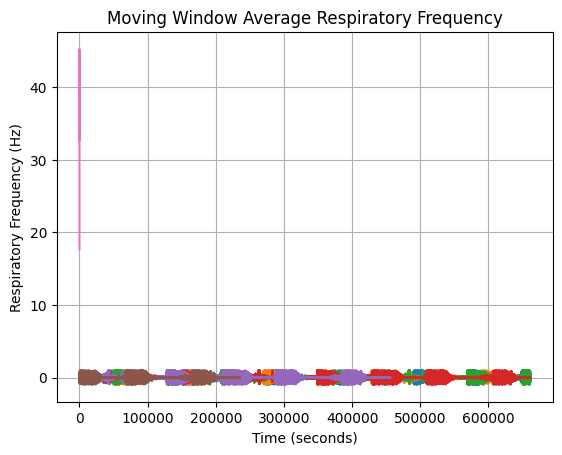

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import scipy

# Load the audio file
audio_file = 'test.mp3'
audio_data, sr = librosa.load(audio_file)

# Set the window size and overlap in seconds
window_size = 30
overlap = 10

# Calculate the number of samples in the window
window_samples = int(sr * window_size)
overlap_samples = int(sr * overlap)

# Calculate the number of windows in the audio
num_windows = len(audio_data) // overlap_samples

# Initialize arrays to store the respiratory frequency and time for each window
respiratory_frequencies = np.zeros(num_windows)
window_times = np.zeros(num_windows)

# Iterate over each window
for i in range(num_windows):
    # Calculate the start and end samples of the current window
    start = i * overlap_samples
    end = start + window_samples

    # Extract the current window
    window = audio_data[start:end]
    
    plt.plot(window)

    # Calculate the envelope of the window using Hilbert transform
    envelope = np.abs(hilbert(window))

    # Calculate the short-term Fourier transform (STFT) of the envelope
    stft = np.abs(librosa.stft(envelope))

    # Calculate the spectral centroid of the STFT
    spectral_centroids = librosa.feature.spectral_centroid(S=stft, sr=sr)

    # Find the index of the peak spectral centroid
    peak_index = np.argmax(spectral_centroids)

    # Calculate the respiratory frequency in Hz
    respiratory_frequency = spectral_centroids[0, peak_index] * sr / len(window)

    # Store the respiratory frequency and time for the current window
    respiratory_frequencies[i] = respiratory_frequency
    window_times[i] = start / sr

# Calculate the moving average of the respiratory frequency
window_size_sec = window_size - overlap
moving_average = np.convolve(respiratory_frequencies, np.ones(window_size_sec) / window_size_sec, mode='same')

# Create a time array for the moving average
moving_average_times = np.linspace(window_size_sec / 2, len(audio_data) / sr - window_size_sec / 2, len(moving_average))

# Plot the moving average calculated frequency vs time
plt.plot(moving_average_times, moving_average)
plt.xlabel('Time (seconds)')
plt.ylabel('Respiratory Frequency (Hz)')
plt.title('Moving Window Average Respiratory Frequency')
plt.grid(True)
plt.show()


/Users/dac/miniconda3/envs/3.10/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


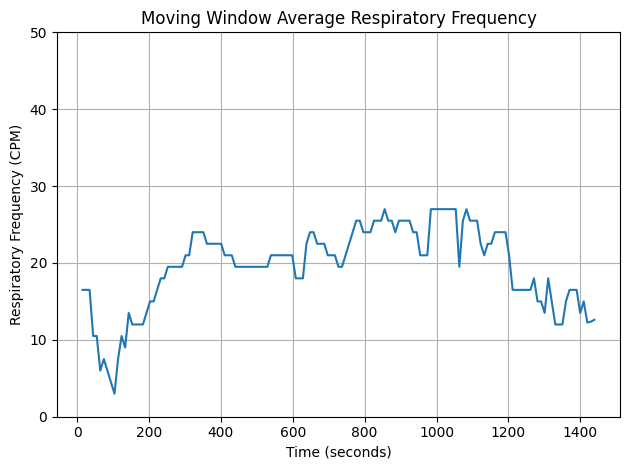

In [3]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy import interpolate
from scipy.signal import hilbert, butter, filtfilt
from pydub import AudioSegment
import scipy

# Load the audio file
audio_file = 'test2.wav'


# Specify the path to your MP3 file

# Load the MP3 file
#audio = AudioSegment.from_mp3(audio_file)
# Extract the audio data as a NumPy array
#audio_data = np.array(audio.get_array_of_samples())

# Extract the sample rate from the audio object
#sr = audio.frame_rate
audio_data, sr = librosa.load(audio_file)

# Set the window size and overlap in seconds
window_size = 40
overlap = 10

# Calculate the number of samples in the window
window_samples  = int(sr * window_size)
overlap_samples = int(sr * overlap)

# Calculate the number of windows in the audio
num_windows = len(audio_data) // overlap_samples

# Calculate the moving average of the respiratory frequency
window_size_sec = window_size - overlap
moving_average = np.zeros(num_windows)

# Create an array to store the mosaic plots
mosaics = np.zeros((num_windows, window_samples))

cutoff_freq = 3  # in Hz

# Calculate the filter coefficients
b, a = butter(4, cutoff_freq / (sr / 2), btype='low')

# Iterate over each window
for i in range(num_windows):
    # Calculate the start and end samples of the current window
    start = i * overlap_samples
    end = start + window_samples

    # Extract the current window
    window = audio_data[start:end]

    # Calculate the envelope of the window using Hilbert transform
    envelope = np.abs(hilbert(window))
    
    # Set the lowpass filter parameters
   

    # Apply the lowpass filter to the signal
    envelope = filtfilt(b, a, envelope)
    smoothing = 2000
    # Apply UnivariateSpline interpolation with smoothing factor of 3000
    spline = interpolate.UnivariateSpline(np.arange(len(envelope)), envelope, s=smoothing)
    interpolated_envelope = spline(np.arange(len(envelope)))

    times = librosa.samples_to_time(np.arange(len(interpolated_envelope)), sr=sr)


    N = len(times)
    # sample spacing
    T = 1.0 / sr
    x = np.linspace(0.0, N*T, N, endpoint=False)
    yf = scipy.fft.fft(interpolated_envelope)
    xf = scipy.fft.fftfreq(N, T)[:N//2]

    freqs = xf
    start_idx = np.argmax(freqs >= 0.05)
    end_idx = np.argmax(freqs >= 0.6)

    # Extract the magnitude spectrum within the desired frequency range

    # Find the index of the largest magnitude within the frequency range
    #max_freq_idx = np.argmax(stft[start_idx:end_idx+1, :])
    max_amplitude_freq = freqs[start_idx:end_idx][np.argmax(np.abs(yf[start_idx:end_idx]))]

    # Get the corresponding frequency value
    #max_freq = freqs[start_idx:end_idx+1][max_freq_idx]
    # Store the respiratory frequency in the moving average array
    moving_average[i] = max_amplitude_freq*60

    # Store the windowed data in the mosaic array
    #mosaics[i] = window

    # # Plot the current windowed data
    # plt.figure()
    # plt.plot(interpolated_envelope)
    # plt.xlabel('Sample')
    # plt.ylabel('Amplitude')
    # plt.title(f'Window {i+1}')
    # plt.grid(True)

# Create a time array for the moving average
moving_average_times = np.linspace(window_size_sec / 2, len(audio_data) / sr - window_size_sec / 2, len(moving_average))

# Plot the moving average calculated frequency vs time
plt.figure()
plt.plot(moving_average_times, moving_average)
plt.xlabel('Time (seconds)')
plt.ylabel('Respiratory Frequency (CPM)')
plt.title('Moving Window Average Respiratory Frequency')
plt.grid(True)

# # Display the mosaic of windowed data
# fig, axes = plt.subplots(num_windows, 1, figsize=(8, 6))
# for i in range(num_windows):
#     axes[i].plot(mosaics[i])
#     axes[i].set_xlabel('Sample')
#     axes[i].set_ylabel('Amplitude')
#     axes[i].set_title(f'Window {i+1}')
#     axes[i].grid(True)
plt.ylim(0, 50)
plt.tight_layout()
plt.show()


In [14]:
import fitparse

def get_heart_rate_data(file_path):
    heart_rate_data = []
    
    with fitparse.FitFile(file_path) as fit_file:
        for record in fit_file.get_messages('record'):
            for data in record:
                if data.name == 'heart_rate':
                    heart_rate_data.append(data.value)
    
    return heart_rate_data

# Usage example
file_path = 'test2.fit'
heart_rate_values = get_heart_rate_data(file_path)

# Printing heart rate values
i=0
for value in heart_rate_values:
    i+=1
    print(value,i)


90 1
86 2
86 3
80 4
85 5
86 6
86 7
89 8
92 9
93 10
92 11
90 12
89 13
91 14
91 15
93 16
96 17
101 18
103 19
106 20
105 21
105 22
108 23
109 24
109 25
115 26
115 27
116 28
118 29
119 30
120 31
122 32
124 33
125 34
126 35
127 36
128 37
129 38
130 39
130 40
130 41
131 42
132 43
132 44
131 45
131 46
131 47
132 48
132 49
131 50
131 51
132 52
132 53
132 54
132 55
132 56
132 57
134 58
134 59
133 60
133 61
133 62
134 63
135 64
134 65
135 66
136 67
137 68
135 69
135 70
136 71
136 72
135 73
134 74
134 75
135 76
134 77
132 78
132 79
131 80
130 81
129 82
131 83
133 84
134 85
134 86
136 87
136 88
136 89
137 90
138 91
137 92
137 93
137 94
139 95
138 96
138 97
138 98
139 99
139 100
139 101
139 102
139 103
141 104
142 105
142 106
142 107
142 108
143 109
143 110
142 111
142 112
143 113
144 114
144 115
144 116
144 117
144 118
145 119
146 120
147 121
147 122
146 123
146 124
147 125
147 126
147 127
148 128
148 129
147 130
148 131
148 132
148 133
149 134
150 135
149 136
149 137
150 138
150 139
152 140
152 1

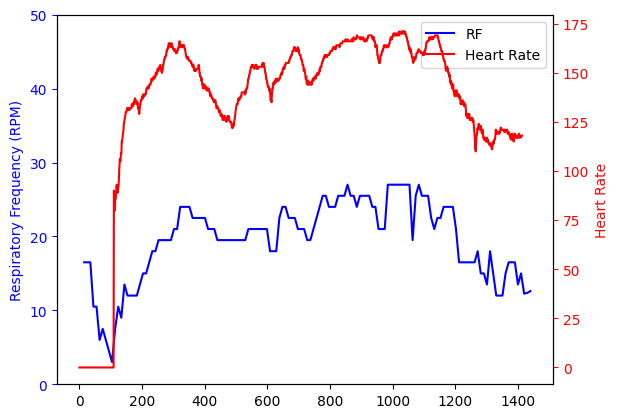

In [29]:
# plt.figure()
# plt.plot(moving_average_times, moving_average)
# plt.xlabel('Time (seconds)')
# plt.ylabel()
# plt.title('Moving Window Average Respiratory Frequency')
# plt.grid(True)


fig, ax1 = plt.subplots()
ax1.plot(moving_average_times,moving_average, color='blue', label='RF')
ax1.set_ylabel('Respiratory Frequency (RPM)', color='blue')
ax1.tick_params(axis='y', colors='blue')
ax1.set_ylim(0, 50) # Plot heart rate curve on existing plot
ax2 = ax1.twinx()  # Create a secondary y-axis on the right side
ax2.plot([0 for i in range(110)]+heart_rate_values, color='red', label='Heart Rate')
ax2.set_ylabel('Heart Rate', color='red')
ax2.tick_params(axis='y', colors='red')

# Optional: Add a legend for the heart rate curve
lines = [ax1.get_lines()[0], ax2.get_lines()[0]]
ax1.legend(lines, [line.get_label() for line in lines])

# Show the plot
plt.show()
plt.show()


In [25]:
[3,4,4]+heart_rate_values

[3,
 4,
 4,
 90,
 86,
 86,
 80,
 85,
 86,
 86,
 89,
 92,
 93,
 92,
 90,
 89,
 91,
 91,
 93,
 96,
 101,
 103,
 106,
 105,
 105,
 108,
 109,
 109,
 115,
 115,
 116,
 118,
 119,
 120,
 122,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 130,
 130,
 131,
 132,
 132,
 131,
 131,
 131,
 132,
 132,
 131,
 131,
 132,
 132,
 132,
 132,
 132,
 132,
 134,
 134,
 133,
 133,
 133,
 134,
 135,
 134,
 135,
 136,
 137,
 135,
 135,
 136,
 136,
 135,
 134,
 134,
 135,
 134,
 132,
 132,
 131,
 130,
 129,
 131,
 133,
 134,
 134,
 136,
 136,
 136,
 137,
 138,
 137,
 137,
 137,
 139,
 138,
 138,
 138,
 139,
 139,
 139,
 139,
 139,
 141,
 142,
 142,
 142,
 142,
 143,
 143,
 142,
 142,
 143,
 144,
 144,
 144,
 144,
 144,
 145,
 146,
 147,
 147,
 146,
 146,
 147,
 147,
 147,
 148,
 148,
 147,
 148,
 148,
 148,
 149,
 150,
 149,
 149,
 150,
 150,
 152,
 152,
 152,
 151,
 152,
 152,
 153,
 153,
 153,
 154,
 153,
 152,
 151,
 151,
 150,
 150,
 151,
 152,
 154,
 154,
 155,
 156,
 157,
 157,
 158,
 158,
 158,
 159,
 15

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy import interpolate
from scipy.signal import hilbert, butter, filtfilt
from pydub import AudioSegment
import scipy
import sounddevice as sd

# Load the audio file
audio_file = 'test2.wav'


# Specify the path to your MP3 file

# Load the MP3 file
#audio = AudioSegment.from_mp3(audio_file)
# Extract the audio data as a NumPy array
#audio_data = np.array(audio.get_array_of_samples())

# Extract the sample rate from the audio object
#sr = audio.frame_rate
audio_data, sr = librosa.load(audio_file)

# Set the window size and overlap in seconds
window_size = 10
overlap = 5

# Calculate the number of samples in the window
window_samples  = int(sr * window_size)
overlap_samples = int(sr * overlap)

# Calculate the number of windows in the audio
num_windows = len(audio_data) // overlap_samples

# Calculate the moving average of the respiratory frequency
window_size_sec = window_size - overlap
moving_average = np.zeros(num_windows)



cutoff_freq = 3  # in Hz

# Calculate the filter coefficients
b, a = butter(4, cutoff_freq / (sr / 2), btype='low')



# Iterate over each window
numero_de_ventana = 14
win = moving_average[i]
if 1:
    # Calculate the start and end samples of the current window
    i= numero_de_ventana
    start = i * overlap_samples
    end = start + window_samples

    # Extract the current window
    window = audio_data[start:end]

    # Calculate the envelope of the window using Hilbert transform
    #envelope = np.abs(hilbert(window))
    
    # Set the lowpass filter parameters
   

    # Apply the lowpass filter to the signal
    #envelope = filtfilt(b, a, envelope)
    smoothing = 2000
    # Apply UnivariateSpline interpolation with smoothing factor of 3000
    #spline = interpolate.UnivariateSpline(np.arange(len(envelope)), envelope, s=smoothing)
    #interpolated_envelope = spline(np.arange(len(envelope)))

    times = librosa.samples_to_time(np.arange(len(interpolated_envelope)), sr=sr)
    # Generate a sample NumPy array
    sample_rate = sr  # Sample rate in Hz

    audio_data = window

    # Play the audio
 

    N = len(times)
    # sample spacing
    T = 1.0 / sr
    x = np.linspace(0.0, N*T, N, endpoint=False)
    yf = scipy.fft.fft(interpolated_envelope)
    xf = scipy.fft.fftfreq(N, T)[:N//2]

    freqs = xf
    start_idx = np.argmax(freqs >= 0.05)
    end_idx = np.argmax(freqs >= 0.6)

    # Extract the magnitude spectrum within the desired frequency range

    # Find the index of the largest magnitude within the frequency range
    #max_freq_idx = np.argmax(stft[start_idx:end_idx+1, :])
    #max_amplitude_freq = freqs[start_idx:end_idx][np.argmax(np.abs(yf[start_idx:end_idx]))]

    # Get the corresponding frequency value
    #max_freq = freqs[start_idx:end_idx+1][max_freq_idx]
    # Store the respiratory frequency in the moving average array
    #moving_average[i] = max_amplitude_freq*60

    # Store the windowed data in the mosaic array
    #mosaics[i] = window

    # # Plot the current windowed data
    # plt.figure()
    # plt.plot(interpolated_envelope)
    # plt.xlabel('Sample')
    # plt.ylabel('Amplitude')
    # plt.title(f'Window {i+1}')
    # plt.grid(True)

# Create a time array for the moving average
#moving_average_times = np.linspace(window_size_sec / 2, len(audio_data) / sr - window_size_sec / 2, len(moving_average))

# Plot the moving average calculated frequency vs time
plt.figure()
plt.plot(window)
plt.xlabel('Time (seconds)')
plt.ylabel('Respiratory Frequency (CPM)')
plt.title('Moving Window Average Respiratory Frequency')
plt.grid(True)

# # Display the mosaic of windowed data
# fig, axes = plt.subplots(num_windows, 1, figsize=(8, 6))
# for i in range(num_windows):
#     axes[i].plot(mosaics[i])
#     axes[i].set_xlabel('Sample')
#     axes[i].set_ylabel('Amplitude')
#     axes[i].set_title(f'Window {i+1}')
#     axes[i].grid(True)
#plt.ylim(0, 50)
plt.tight_layout()
plt.show()
sd.play(audio_data, sample_rate)
sd.wait()

/Users/dac/miniconda3/envs/3.10/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


NameError: name 'i' is not defined

In [51]:
def plot_time_series_with_navigation(x,y,window,jump,sr): 
    import numpy as np
    import matplotlib.pyplot as plt
    from ipywidgets import Button, VBox
    from IPython.display import display, clear_output
    global  win_number 
    win_number = 1 
    # Generate example data
    # x = np.linspace(0, 1000, 1000)
    # y = np.sin(x)

    # Define the window size and jump size
    window_size = window
    jump_size = jump

    # Define the current start index
    global start_index
    start_index = 0
    # Define the plotting function
    def plot_window():
        global start_index
        global  win_number 
        global end_index
        end_index = start_index + window_size

        # Clear previous plot
        clear_output(wait=True)

        # Plot the windowed data
        plt.plot(x[start_index:end_index], y[start_index:end_index], label=f'window {win_number}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Time Series Window')

        # Set the x-axis limits based on the current window
        plt.xlim(x[start_index], x[end_index])

        plt.legend(loc=10)
        # Show the plot
        plt.show()

    # Define the button callback functions
    def next_window(_):
        global  win_number 
        global start_index
        if start_index + jump_size + window_size <= len(x):
            start_index += jump_size
            win_number  += 1
            plot_window()
            display(buttons_box)

    def previous_window(_):
        global  win_number 
        global start_index
        if start_index - jump_size >= 0:
            start_index -= jump_size
            win_number  -= 1
            plot_window()
            display(buttons_box)
            
        

    def play_audio(_):
        global start_index
        global end_index
        sd.play(y[start_index:end_index], sr)
        sd.wait()

    # Create the Next and Back buttons
    next_button = Button(description='Next')
    back_button = Button(description='Back')
    play_button = Button(description='play')

    # Register the button callback functions
    next_button.on_click(next_window)
    back_button.on_click(previous_window)
    play_button.on_click(play_audio)

    # Create a vertical box layout for the buttons
    buttons_box = VBox([back_button, next_button, play_button])

    # Display the initial plot and button box
    plot_window()
    display(buttons_box)


In [31]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy import interpolate
from scipy.signal import hilbert, butter, filtfilt
from pydub import AudioSegment
import scipy

# Load the audio file
audio_file = 'test.mp3'


# Specify the path to your MP3 file

# Load the MP3 file
#audio = AudioSegment.from_mp3(audio_file)
# Extract the audio data as a NumPy array
#audio_data = np.array(audio.get_array_of_samples())

# Extract the sample rate from the audio object
#sr = audio.frame_rate
audio_data, sr = librosa.load(audio_file)
times = librosa.samples_to_time(np.arange(len(audio_data)), sr=sr)


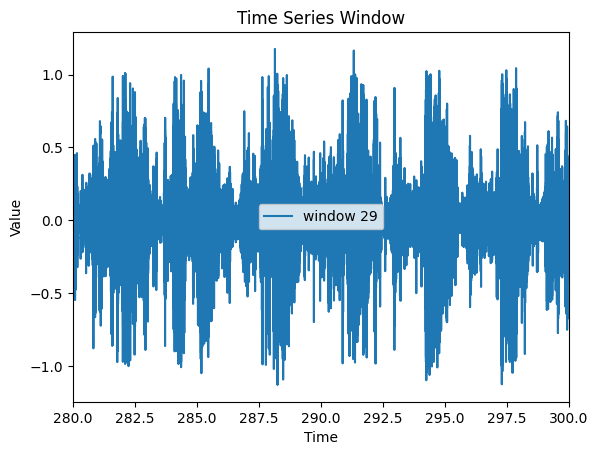

In [52]:
import ipywidgets



############### Load the audio file#######
audio_file = 'test2.wav'           ########
##########################################
# Extract the sample rate from the audio object
#sr = audio.frame_rate
audio_data, sr = librosa.load(audio_file)
times = librosa.samples_to_time(np.arange(len(audio_data)), sr=sr)
window = sr*20# tamanio de ventana a visualizar
jump = sr*10# tamano de overlap de la data anotada
plot_time_series_with_navigation(times,audio_data,window,jump,sr) 


In [29]:
t_max = np.max(times)

rf_points = 2*round(t_max/20)-1

time_data = np.linspace(20,20*round(t_max/20),rf_points)
count = 0
rf_data = [6,6,6,6,5,
           6,6,3,]
# for data in range(len(time_data)):
#     count = count+1 
#     value = input(f'ingrese el dato numero {count}')
#     rf_data.append(int(value))

ValueError: invalid literal for int() with base 10: ''

In [62]:
t_max = np.max(times)

rf_points = 2*round(t_max/20)-1

time_data = np.linspace(20,20*round(t_max/20),rf_points)
# # Step 2: Create predefined lists for 'Time' and 'RF' columns
rf_data = [0.1, 0.5, 0.8, 0.3]

# # Step 3: Create the DataFrame
# data = {'Time': time_data, 'RF': rf_data}
# df = pd.DataFrame(data)

# # Step 4: Save the DataFrame to a CSV file
# csv_file_path = 'data.csv'
# df.to_csv(csv_file_path, index=False)

# print(f"DataFrame saved as '{csv_file_path}' successfully.")


In [63]:
#determinar cuantas muestras quiero ver en cada ventana
sr*5

110250

In [44]:
t_max

60.67197278911565

In [5]:
rf_data

['22',
 '22',
 '222',
 '',
 '',
 '22',
 '2',
 '2',
 '22',
 '2',
 '2',
 '2',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [8]:
value = input('ingrese el dato numero')
